In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Train-Step 1: Data Loading and Preprocessing

## Load the dataset

In [2]:
import pandas as pd

# Load the dataset
input_path = '/work/likeyi/EpiAgent/20250326_CRISPR/All_data_K562_1.csv'
df = pd.read_csv(input_path,usecols=['cell_indices','perturbation','cell_line','ncounts','ngenes'])

# Remove cells with unknown perturbation type
df = df[~df['perturbation'].isna()]

print(df.head())

                                        cell_indices perturbation cell_line  \
0  [180319, 27596, 74826, 782806, 885712, 80532, ...        PRDM9      K562   
1  [957562, 464526, 302935, 430395, 1329485, 1084...        SETD2      K562   
3  [260651, 956169, 501395, 1155953, 190838, 1056...       DNMT3A      K562   
4  [941339, 683424, 1344465, 274028, 1068647, 114...      SMARCB1      K562   
5  [1147519, 640432, 1189255, 1083846, 766692, 10...         CHD5      K562   

   ncounts  ngenes  
0    766.0     318  
1    829.0     343  
3    978.0     419  
4    644.0     268  
5   2370.0     946  


## Create perturbation list

In [3]:
import numpy as np

all_peat_list = list(np.unique(df['perturbation']))
all_peat_list.remove('control')
pert_to_index = {element: index for index, element in enumerate(all_peat_list)}

## Create Dataloader for computing zero-shot cell embeddings

In [4]:
import json
import torch
from epiagent.dataset import CellDataset, collate_fn

Test_pert_list = ['PRDM9','SETD2','SMARCA4','SMARCB1','TET2']
metadata = df.copy()
Train_df = metadata[~metadata['perturbation'].isin(Test_pert_list)]
Test_df = metadata[metadata['perturbation'].isin(Test_pert_list)]

cell_indeces = [json.loads(instance) for instance in Train_df['cell_indices'].tolist()]
cell_dataset = CellDataset(cell_indeces,8192,True)
dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=4, shuffle=False,num_workers=4, collate_fn=collate_fn)

## Load the Pre-trained EpiAgent Model

In [5]:
from epiagent.model import EpiAgent
import torch
import torch.nn as nn

# Specify the path to the pre-trained model
model_path = '/home/chenxiaoyang/program/scCASdata/model/pretrained_EpiAgent.pth'

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the EpiAgent model with appropriate configurations
pretrained_model = EpiAgent(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.)
)

# Load the pre-trained weights into the model
pretrained_model.load_state_dict(torch.load(model_path))

# Move the model to the specified device
pretrained_model.to(device)

2025-05-15 10:09:48.825248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 10:09:48.837556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747274988.850691 2376785 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747274988.854679 2376785 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747274988.865815 2376785 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

EpiAgent(
  (cCRE_embedding): Embedding(1355449, 512)
  (rank_embedding): Embedding(8192, 512)
  (EpiAgent_transformer): BertEncoder(
    (layers): ModuleList(
      (0-17): 18 x Block(
        (mixer): MHA(
          (Wqkv): LinearResidual(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashSelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): FlashCrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (d

## Compute the Zero-shot cell embeddings

In [6]:
from torch.cuda.amp import autocast
import umap

pretrained_model.eval()

cell_embeddings = []
for _, batch in enumerate(dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():
        output_embeddings = pretrained_model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)
umap_embeddings = umap.UMAP(n_components=2, random_state=32).fit_transform(np.array(cell_embeddings))

/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


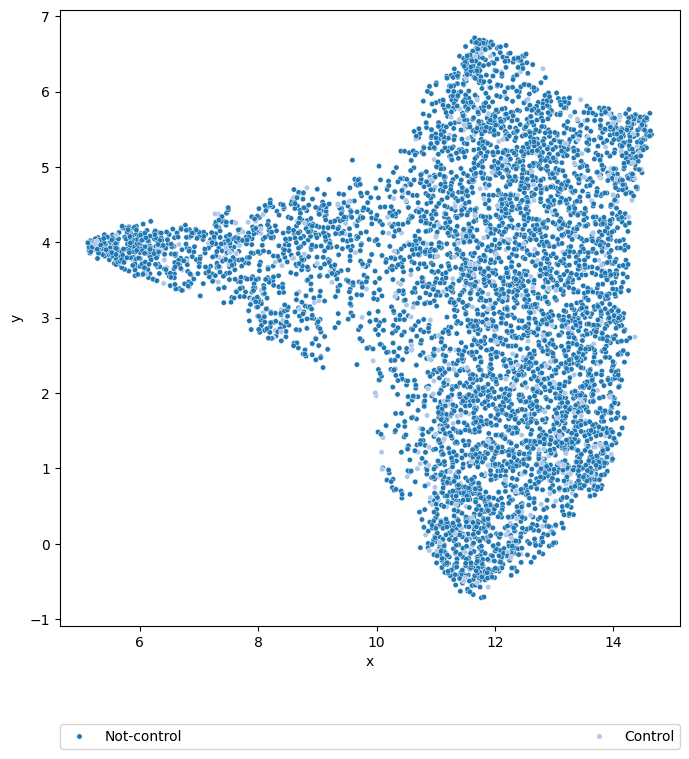

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization perturbation of 'Control' vs 'Not-control'
cell_label = Train_df["perturbation"].tolist()
new_cell_label = ['Control' if item == 'control' else 'Not-control' for item in cell_label]
data = pd.DataFrame({'x': umap_embeddings[:, 0], 'y': umap_embeddings[:, 1], 'label': new_cell_label})

plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', hue='label',palette='tab20',s=15, data=data)
plt.legend(bbox_to_anchor=(0., -0.2, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

## Match cells with OT

In [8]:
import ot

torch.cuda.empty_cache()

# Extract the indices of ‘Stimulated’ and ‘Resting’ from the ‘condition’ column
match_types = []
match_idxs = []
for pert in np.unique(Train_df['perturbation']):
    if pert == 'control':
        continue
    
    stim_indices = np.array(Train_df['perturbation'] == pert)
    control_indices = np.array(Train_df['perturbation'] == 'control')

    # Split cell_embeddings into stim and control based on the indices
    stim = cell_embeddings[stim_indices]
    ctrl = cell_embeddings[control_indices]
    M = ot.dist(stim, ctrl, metric='cosine')
    G = ot.emd(torch.ones(stim.shape[0]) / stim.shape[0],
               torch.ones(ctrl.shape[0]) / ctrl.shape[0],
               torch.tensor(M), numItermax=100000)
    match_idx = torch.max(G, 0)[1].numpy()

    match_types.append(pert + '-' + 'control')
    match_idxs.append(match_idx)
    
match_idx = dict(zip(match_types, match_idxs))

## Create Data for train and test

In [9]:
import scanpy as sc

# Load the anndata object
adata_path = '/data/user/chenxiaoyang/data/scATAC/Liscovitch-BrauerSanjana2021/K562_1/tfidf_data.h5ad'
adata = sc.read_h5ad(adata_path)

# Select the top 50,000 peaks ranked by chromatin accessibility
peak_sum = np.sum(adata.X, axis=0)
peak_sum = np.array(peak_sum).reshape(-1)
peak_sum_sortidx = np.argsort(peak_sum)[::-1]
peak_sum_sortidx = peak_sum_sortidx[:50000]
adata = adata[:, peak_sum_sortidx]
adata = adata[~adata.obs['perturbation'].isna()]

# Split to 'train_adata' and 'test_adata'
train_adata = adata[~adata.obs['perturbation'].isin(Test_pert_list)]
test_adata = adata[adata.obs['perturbation'].isin(Test_pert_list)]

In [10]:
New_train_df = pd.DataFrame()
Train_control_df = Train_df[Train_df['perturbation'] == 'control'].copy()
Train_control_df.reset_index(drop=True, inplace=True)
Train_control_df['predicted_cell_indices'] = Train_control_df['cell_indices']

train_resting = train_adata[train_adata.obs['perturbation'] == 'control']
New_train_df = pd.concat([New_train_df, Train_control_df], ignore_index=True)
New_train_adata = train_resting

for pert in np.unique(Train_df['perturbation']): 
    if pert == 'control':
        continue
    Train_stimulation_df = Train_df[Train_df['perturbation'] == pert].copy()
    Train_stimulation_df.reset_index(drop=True, inplace=True)

    train_stimulated = train_adata[train_adata.obs['perturbation'] == pert]
    
    # Add a 'predicted_cell_indices' column with the same values as the 'cell_indices column'
    Train_stimulation_df['predicted_cell_indices'] = Train_stimulation_df['cell_indices']

    Train_control_mapping_df = Train_control_df.copy()
    # Update the 'predicted_cell_indices' column in Train_control_mapping_df
    Train_control_mapping_df['predicted_cell_indices'] = Train_stimulation_df.loc[match_idx[pert + '-' + 'control'], 'cell_indices'].values
    Train_control_mapping_df['perturbation'] = "control_mapping_to_" + pert
    # Merge the three DataFrames
    New_train_df = pd.concat([New_train_df, Train_stimulation_df, Train_control_mapping_df], ignore_index=True)

    New_train_adata = sc.concat([New_train_adata, train_stimulated, train_stimulated[match_idx[pert + '-' + 'control']]], join='outer')

New_train_df.reset_index(drop=True, inplace=True)
New_train_df.to_csv("./New_train_df.csv")

/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/s

In [11]:
New_train_adata.obs.index = [str(i) for i in range(New_train_adata.shape[0])]
New_train_df = pd.read_csv("./New_train_df.csv",index_col=0)
assert New_train_adata.shape[0] == New_train_df.shape[0], "The number of rows in New_train_df must match the number of cells in the New_train_adata."
New_train_adata.obs = New_train_df
New_train_adata.obs.index = [str(i) for i in range(New_train_adata.shape[0])]
New_train_adata.write_h5ad('./New_train_adata.h5ad')

/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [12]:
New_test_df = pd.DataFrame()
Test_control_df = Train_df[Train_df['perturbation'] == 'control'].copy()
Test_control_df.reset_index(drop=True, inplace=True)

test_resting = train_adata[train_adata.obs['perturbation'] == 'control']
New_test_df = pd.concat([New_test_df, Test_control_df], ignore_index=True)
New_test_adata = test_resting

for pert in np.unique(Test_df['perturbation']): 
    if pert == 'control':
        continue
    Test_stimulation_df = Test_df[Test_df['perturbation'] == pert].copy()

    # 重新标号索引，从0开始
    Test_stimulation_df.reset_index(drop=True, inplace=True)

    test_stimulated = test_adata[test_adata.obs['perturbation'] == pert]

    Test_control_mapping_df = Test_control_df.copy()
    Test_control_mapping_df['perturbation'] = "control_mapping_to_" + pert
    # 合并这三个DataFrame
    New_test_df = pd.concat([New_test_df, Test_stimulation_df, Test_control_mapping_df], ignore_index=True)

    New_test_adata = sc.concat([New_test_adata, test_stimulated, test_resting], join='outer')

New_test_df.reset_index(drop=True, inplace=True)
New_test_df.to_csv("./New_test_df.csv")

/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/s

In [13]:
New_test_adata.obs.index = [str(i) for i in range(New_test_adata.shape[0])]
New_test_df = pd.read_csv("./New_test_df.csv",index_col=0)
assert New_test_adata.shape[0] == New_test_df.shape[0], "The number of rows in New_test_df must match the number of cells in the New_test_adata."
New_test_adata.obs = New_test_df
New_test_adata.write_h5ad('./New_test_adata.h5ad')

/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


## Create GO and GO_weight

In [14]:
from multiprocessing import Pool
import networkx as nx
import os
from tqdm import tqdm

class GeneSimNetwork():
    """
    GeneSimNetwork class

    Args:
        edge_list (pd.DataFrame): edge list of the network
        gene_list (list): list of gene names
        node_map (dict): dictionary mapping gene names to node indices

    Attributes:
        edge_index (torch.Tensor): edge index of the network
        edge_weight (torch.Tensor): edge weight of the network
        G (nx.DiGraph): networkx graph object
    """
    def __init__(self, edge_list, gene_list, node_map):
        """
        Initialize GeneSimNetwork class
        """

        self.edge_list = edge_list
        self.G = nx.from_pandas_edgelist(self.edge_list, source='source',
                        target='target', edge_attr=['importance'],
                        create_using=nx.DiGraph())    
        self.gene_list = gene_list
        for n in self.gene_list:
            if n not in self.G.nodes():
                self.G.add_node(n)

        edge_index_ = [(node_map[e[0]], node_map[e[1]]) for e in
                      self.G.edges]
        self.edge_index = torch.tensor(edge_index_, dtype=torch.long).T
        #self.edge_weight = torch.Tensor(self.edge_list['importance'].values)
        
        edge_attr = nx.get_edge_attributes(self.G, 'importance') 
        importance = np.array([edge_attr[e] for e in self.G.edges])
        self.edge_weight = torch.Tensor(importance)

def make_GO(data_path, pert_list, data_name, num_workers=25, save=True):
    """
    Creates Gene Ontology graph from a custom set of genes
    """

    fname = './data/go_essential_' + data_name + '.csv'
    if os.path.exists(fname):
        return pd.read_csv(fname)

    with open(os.path.join(data_path, 'gene2go_all.pkl'), 'rb') as f:
        gene2go = pickle.load(f)
    gene2go = {i: gene2go[i] for i in pert_list}

    print('Creating custom GO graph, this can take a few minutes')
    with Pool(num_workers) as p:
        all_edge_list = list(
            tqdm(p.imap(get_GO_edge_list, ((g, gene2go) for g in gene2go.keys())),
                      total=len(gene2go.keys())))
    edge_list = []
    for i in all_edge_list:
        edge_list = edge_list + i

    df_edge_list = pd.DataFrame(edge_list).rename(
        columns={0: 'source', 1: 'target', 2: 'importance'})
    
    if save:
        print('Saving edge_list to file')
        df_edge_list.to_csv(fname, index=False)

    return df_edge_list

def get_similarity_network(data_path, data_name, pert_list=None, k=20):

    df_jaccard = make_GO(data_path, pert_list, data_name)

    df_out = df_jaccard.groupby('target').apply(lambda x: x.nlargest(k + 1,['importance'])).reset_index(drop = True)

    return df_out

def get_GO_edge_list(args):
    """
    Get gene ontology edge list
    """
    g1, gene2go = args
    edge_list = []
    for g2 in gene2go.keys():
        score = len(gene2go[g1].intersection(gene2go[g2])) / len(
            gene2go[g1].union(gene2go[g2]))
        if score > 0.1:
            edge_list.append((g1, g2, score))
    return edge_list

In [15]:
import pickle

with open("./data/gene2go_all.pkl", "rb") as f:
    data = pickle.load(f)

# Read or Create GO
data_name='brauersanjana2021_k562_1'
edge_list = get_similarity_network(data_path='./data',data_name=data_name,pert_list=all_peat_list)

sim_network = GeneSimNetwork(edge_list, all_peat_list, node_map = pert_to_index)
G_go = sim_network.edge_index
G_go_weight = sim_network.edge_weight

np.save(data_name + '_G_go.npy', G_go.cpu().numpy())
np.save(data_name + '_G_go_weight.npy', G_go_weight.cpu().numpy())

Creating custom GO graph, this can take a few minutes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 29428.80it/s]

Saving edge_list to file



/tmp/ipykernel_2376785/2232441634.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df_jaccard.groupby('target').apply(lambda x: x.nlargest(k + 1,['importance'])).reset_index(drop = True)


# Train-Step2: Load and Process the Pre-trained model for finetune

In [16]:
from epiagent.model import EpiAgent_PT

# Initialize the EpiAgent model with appropriate configurations
pretrained_model = EpiAgent_PT(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.),
    GO=G_go,
    GO_weight=G_go_weight,
    all_pert_list=all_peat_list
)

# Specify the path to the pre-trained model
model_path = '/home/chenxiaoyang/program/scCASdata/model/pretrained_EpiAgent.pth'

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained weights into the model
pretrained_model.load_state_dict(torch.load(model_path),strict=False)

# Move the model to the specified device
pretrained_model.to(device)

/home/likeyi/program/EpiAgent/20250512_tutorail/epiagent/model.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.GO = torch.tensor(GO)
/home/likeyi/program/EpiAgent/20250512_tutorail/epiagent/model.py:709: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.GO_weight = torch.tensor(GO_weight)


EpiAgent_PT(
  (cCRE_embedding): Embedding(1355449, 512)
  (rank_embedding): Embedding(8192, 512)
  (EpiAgent_transformer): BertEncoder(
    (layers): ModuleList(
      (0-17): 18 x Block(
        (mixer): MHA(
          (Wqkv): LinearResidual(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashSelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): FlashCrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
       

In [17]:
pretrained_model.signal_decoder = nn.Linear(512, 50000)
pretrained_model.criterion_SR = nn.MSELoss()
original_vocab_size = pretrained_model.vocab_size
pretrained_model.vocab_size = original_vocab_size + len(all_peat_list)

original_weights = pretrained_model.cCRE_embedding.weight.data
new_embedding = nn.Embedding(pretrained_model.vocab_size, 512)
new_embedding.weight.data[:original_vocab_size] = original_weights[:original_vocab_size]
pretrained_model.cCRE_embedding = new_embedding

# Ensure the CCA loss uses a positive weight of 1
pretrained_model.criterion_CCA.pos_weight = torch.tensor(1.)

# Train-Step 3: Create Datasets and DataLoaders

## Creating Training Dataset and DataLoader

In [18]:
from epiagent.dataset import TrainCellDatasetForPT, collate_fn_for_PT_train

# Create the training dataset
train_dataset = TrainCellDatasetForPT(
    adata=New_train_adata,
    pert_to_index=pert_to_index)

# Create the training DataLoader
train_batch_size = 2
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=train_batch_size, 
    shuffle=True, 
    num_workers=2,
    collate_fn=collate_fn_for_PT_train)

## Creating Inference Dataset and DataLoader

In [19]:
from epiagent.dataset import TestCellDatasetForPT, collate_fn_for_PT_test

# Create the inference dataset
test_dataset = TestCellDatasetForPT(adata=New_test_adata)

# Create the inference DataLoader
inference_batch_size = 2
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=inference_batch_size, 
    shuffle=False, 
    num_workers=2, 
    collate_fn=collate_fn_for_PT_test)

cell_label = New_test_adata.obs['perturbation'].tolist()

# Train-Step4: Fine-tuning the EpiAgent Model

In [20]:
from epiagent.train import fine_tune_epiagent_for_UFE

# Fine-tune the model
fine_tuned_model = fine_tune_epiagent_for_UFE(
    model=pretrained_model,
    train_dataloader=train_dataloader,
    num_steps=500000, 
    save_dir='./model/fine_tune/PT/demo_dataset/',
    device=device,
    learning_rate=5e-5,
    save_steps=20000,
    log_steps=500,
    warmup_steps=10000,
    is_logging=True
)

Model directory created at: ./model/fine_tune/PT/demo_dataset/


/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch [1/74], Step [500/6717], Total Loss: 1.2166, CCA Loss: 0.5943, SR Loss: 0.6223
CCA Metrics - Positive Acc: 0.6194, Negative Acc: 0.7848, AUROC: 0.7733, AUPRC: 0.7896
Epoch [1/74], Step [1000/6717], Total Loss: 1.1893, CCA Loss: 0.5781, SR Loss: 0.6112
CCA Metrics - Positive Acc: 0.7130, Negative Acc: 0.6844, AUROC: 0.7560, AUPRC: 0.7333
Epoch [1/74], Step [1500/6717], Total Loss: 1.1545, CCA Loss: 0.5641, SR Loss:

# Test-Step 1: Compute the Fine-tuned cell embeddings

In [2]:
import torch
from epiagent.model import EpiAgent_PT
import scanpy as sc
from epiagent.dataset import TestCellDatasetForPT, collate_fn_for_PT_test
import numpy as np
import pandas as pd
import torch.nn as nn

# Load supporting data
input_path = '/work/likeyi/EpiAgent/20250326_CRISPR/All_data_K562_1.csv'
df = pd.read_csv(input_path,usecols=['cell_indices','perturbation','cell_line','ncounts','ngenes'])
df = df[~df['perturbation'].isna()]
all_peat_list = list(np.unique(df['perturbation']))
all_peat_list.remove('control')
pert_to_index = {element: index for index, element in enumerate(all_peat_list)}

G_go = np.load("./brauersanjana2021_k562_1_G_go.npy")
G_go_weight = np.load("./brauersanjana2021_k562_1_G_go_weight.npy")

# Load the Fine-tuned model
model_path = "/home/likeyi/program/EpiAgent/20250512_tutorail/model/fine_tune/PT/demo_dataset/checkpoint_step_480000.pth"
model = EpiAgent_PT(
    vocab_size=1355449 + len(all_peat_list),
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.),
    GO=G_go,
    GO_weight=G_go_weight,
    all_pert_list=all_peat_list
)
model.signal_decoder = nn.Linear(512, 50000)
model.criterion_SR = nn.MSELoss()

model.load_state_dict(torch.load(model_path, map_location='cpu'))

# Load the processed Test Anndata
adata = sc.read_h5ad("./New_test_adata.h5ad")

# Create Dataset and DataLoader
test_dataset = TestCellDatasetForPT(adata=adata,pert_to_index=pert_to_index)

inference_batch_size = 2
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=inference_batch_size, 
    shuffle=False, 
    num_workers=2, 
    collate_fn=collate_fn_for_PT_test)

2025-05-16 21:30:16.863679: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 21:30:16.875995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747402216.889319 3895743 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747402216.893372 3895743 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747402216.904601 3895743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
from torch.cuda.amp import autocast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

cell_embeddings = []
predicted_signals = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:]
        predicted_signal = model.signal_decoder(output_embeddings).cpu().detach().numpy()
        output_embeddings = output_embeddings.cpu().detach().numpy()

    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
    for signal in predicted_signal:
        predicted_signals.append(signal)
        
cell_embeddings = np.array(cell_embeddings)
predicted_signals = np.array(predicted_signals)

adata.layers['predicted_signals'] = predicted_signals
adata.obsm['cell_embeddings'] = cell_embeddings

# Test-Step 2: Compute the metric

## Pearson correlation coefficients

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_distances
import ot

def cal_DE_peaks(adata, pert):
    New_test_adata = adata.copy()
    # Compute differential peaks between Stimulated and Resting conditions
    sc.tl.rank_genes_groups(New_test_adata, groupby='perturbation', groups=[pert], reference='control', method='wilcoxon')
    
    # adjusted p-values, log fold changes, and related information
    differential_peaks_stim_vs_rest = pd.DataFrame({
        'names': New_test_adata.uns['rank_genes_groups']['names'][pert],
        'pvals_adj': New_test_adata.uns['rank_genes_groups']['pvals_adj'][pert],
        'logfoldchanges': New_test_adata.uns['rank_genes_groups']['logfoldchanges'][pert]
    })
    
    # Sort the adjusted p-values
    differential_peaks_stim_vs_rest = differential_peaks_stim_vs_rest.sort_values(by='pvals_adj')

    # Detect DEGs (Differentially Expressed Genes)
    new_adata = New_test_adata.copy()
    sc.tl.rank_genes_groups(new_adata, groupby='perturbation', groups=["control_mapping_to_" + pert], reference='control', method='wilcoxon', layer='predicted_signals')

    
    # adjusted p-values, log fold changes, and related information
    differential_genes_rest_map_to_stim_vs_rest = pd.DataFrame({
        'names': new_adata.uns['rank_genes_groups']['names']["control_mapping_to_" + pert],
        'pvals_adj': new_adata.uns['rank_genes_groups']['pvals_adj']["control_mapping_to_" + pert],
        'logfoldchanges': new_adata.uns['rank_genes_groups']['logfoldchanges']["control_mapping_to_" + pert]
    })
    
    # ort the adjusted p-values
    differential_genes_rest_map_to_stim_vs_rest = differential_genes_rest_map_to_stim_vs_rest.sort_values(by='pvals_adj')

    return differential_peaks_stim_vs_rest,differential_genes_rest_map_to_stim_vs_rest

def cal_DE_peak_Pearson_and_Jaccard(adata,pert,differential_peaks_stim_vs_rest,n=1000):
    New_test_adata = adata.copy()
    
    # Select the top n differential peaks
    top_n_peaks = differential_peaks_stim_vs_rest.head(n)['names']
    
    # Create a new AnnData object retaining only the top n differential peaks
    top_n_adata = New_test_adata[:, New_test_adata.var.index.isin(top_n_peaks)].copy()
    
    # Extract data with condition ‘Stimulated’ from the raw dataset
    stimulated_raw = top_n_adata[top_n_adata.obs['perturbation'] == pert]
    stimulated_raw_matrix = stimulated_raw.X.toarray()
    stimulated_raw_mean = np.mean(stimulated_raw_matrix, axis=0)
    
    # Extract data with condition ‘Resting_mapping_to_stimulated’ from predicted_signals
    predicted_matrix = top_n_adata.layers['predicted_signals']#.toarray()
    predicted_obs = top_n_adata.obs['perturbation'] == "control_mapping_to_" + pert
    predicted_signals_matrix = predicted_matrix[predicted_obs, :]
    predicted_signals_mean = np.mean(predicted_signals_matrix, axis=0)
    
    pearson_corr = np.corrcoef(stimulated_raw_mean, predicted_signals_mean)[0, 1]
    return pearson_corr

In [5]:
differential_peaks_stim_vs_rests = []
differential_genes_rest_map_to_stim_vs_rests = []
indexs = []
for pert in np.unique(adata.obs['perturbation']):
    if 'control' in  pert:
        continue
    if sum(adata.obs['perturbation'] == pert) <= 1:
        continue
    print(pert)
    differential_peaks_stim_vs_rests.append(cal_DE_peaks(adata, pert)[0])
    differential_genes_rest_map_to_stim_vs_rests.append(cal_DE_peaks(adata, pert)[1])

PRDM9


/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


SETD2


/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


SMARCA4


/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


SMARCB1


/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


TET2


/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/likeyi/anaconda3/envs/EpiAgent_MO/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [6]:
for n in [100,200,500,1000,2000]:
    print(f'n = {n}')
    pearson_corrs = []
    jaccard_sims = []
    idx = 0
    for pert in np.unique(adata.obs['perturbation']):
        if 'control' in  pert:
            continue
        if sum(adata.obs['perturbation'] == pert) <= 1:
            continue
        pearson_corr = cal_DE_peak_Pearson_and_Jaccard(adata, pert, differential_peaks_stim_vs_rests[idx], n=n)
        pearson_corrs.append(pearson_corr)

    pearson_corrs = np.array(pearson_corrs)
    print(f'Mean value of Pearson correlation: {np.mean(pearson_corrs):.4f}')
    print(f'Std value of Pearson correlation: {np.std(pearson_corrs):.4f}')

n = 100
Mean value of Pearson correlation: 0.7782
Std value of Pearson correlation: 0.0657
n = 200
Mean value of Pearson correlation: 0.7576
Std value of Pearson correlation: 0.0614
n = 500
Mean value of Pearson correlation: 0.7315
Std value of Pearson correlation: 0.0573
n = 1000
Mean value of Pearson correlation: 0.7076
Std value of Pearson correlation: 0.0674
n = 2000
Mean value of Pearson correlation: 0.6736
Std value of Pearson correlation: 0.0696


## Accuracy for accessibility change

In [7]:
def cal_regulated_rate(adata,pert,differential_peaks_stim_vs_rest,m=1000):
    New_test_adata = adata.copy()
    
    # Extract top m upregulated and top m downregulated peaks in Stimulated based on smallest p-values
    upregulated_peaks = differential_peaks_stim_vs_rest[differential_peaks_stim_vs_rest['logfoldchanges'] > 0].sort_values(by='pvals_adj').head(m)['names']
    downregulated_peaks = differential_peaks_stim_vs_rest[differential_peaks_stim_vs_rest['logfoldchanges'] < 0].sort_values(by='pvals_adj').head(m)['names']
    
    # Extract the matrix of the selected top m upregulated and m downregulated peaks from New_test_adata
    upregulated_data = New_test_adata[:, New_test_adata.var.index.isin(upregulated_peaks)].copy()
    downregulated_data = New_test_adata[:, New_test_adata.var.index.isin(downregulated_peaks)].copy()
    
    # Extract the subset of data where the condition is either 'Resting' or 'Resting_mapping_to_stimulated'
    resting_indices = np.where(New_test_adata.obs['perturbation'] == 'control')[0]
    resting_mapping_to_stimulated_indices = np.where(New_test_adata.obs['perturbation'] == "control_mapping_to_" + pert)[0]
    
    # Calculate the mean signal change for upregulated peaks
    upregulated_resting_mean = np.mean(upregulated_data[resting_indices, :].X.toarray(), axis=0)
    upregulated_mapping_to_stimulated_mean = np.mean(upregulated_data[resting_mapping_to_stimulated_indices, :].layers['predicted_signals'], axis=0)
    
    # Calculate the mean signal change for downregulated peaks
    downregulated_resting_mean = np.mean(downregulated_data[resting_indices, :].X.toarray(), axis=0)
    downregulated_mapping_to_stimulated_mean = np.mean(downregulated_data[resting_mapping_to_stimulated_indices, :].layers['predicted_signals'], axis=0)
    
    # Check whether the mean signal change indicates an increase or decrease
    upregulated_change = upregulated_mapping_to_stimulated_mean - upregulated_resting_mean
    downregulated_change = downregulated_mapping_to_stimulated_mean - downregulated_resting_mean
    
    # Compute increase ratio for upregulated peaks and decrease ratio for downregulated peaks
    upregulated_increase_ratio = np.sum(upregulated_change > 0) / m
    downregulated_decrease_ratio = np.sum(downregulated_change < 0) / m
    
    return upregulated_increase_ratio, downregulated_decrease_ratio

In [9]:
for n in [100,200,500,1000,2000]:
    print(f'n = {n}')
    upregulated_increase_ratios = []
    downregulated_decrease_ratios = []

    for pert in np.unique(adata.obs['perturbation']):
        if 'control' in  pert:
            continue
        if sum(adata.obs['perturbation'] == pert) <= 1:
            continue
        upregulated_increase_ratio, downregulated_decrease_ratio = cal_regulated_rate(adata,pert,differential_peaks_stim_vs_rests[idx],m=n)
        upregulated_increase_ratios.append(upregulated_increase_ratio)
        downregulated_decrease_ratios.append(downregulated_decrease_ratio)

    upregulated_increase_ratios = np.array(upregulated_increase_ratios)
    downregulated_decrease_ratios = np.array(downregulated_decrease_ratios)
    print(f'Mean value of Upregulated increase ratios: {np.mean(upregulated_increase_ratios):.4f}')
    print(f'Std value of Upregulated increase ratios: {np.std(upregulated_increase_ratios):.4f}')
    print(f'Mean value of Downregulated decrease ratios: {np.mean(downregulated_decrease_ratios):.4f}')
    print(f'Std value of Downregulated decrease ratios: {np.std(downregulated_decrease_ratios):.4f}')

n = 100
Mean value of Upregulated increase ratios: 0.8580
Std value of Upregulated increase ratios: 0.0223
Mean value of Downregulated decrease ratios: 0.8940
Std value of Downregulated decrease ratios: 0.0120
n = 200
Mean value of Upregulated increase ratios: 0.8970
Std value of Upregulated increase ratios: 0.0117
Mean value of Downregulated decrease ratios: 0.7980
Std value of Downregulated decrease ratios: 0.0129
n = 500
Mean value of Upregulated increase ratios: 0.8984
Std value of Upregulated increase ratios: 0.0051
Mean value of Downregulated decrease ratios: 0.6992
Std value of Downregulated decrease ratios: 0.0117
n = 1000
Mean value of Upregulated increase ratios: 0.8782
Std value of Upregulated increase ratios: 0.0058
Mean value of Downregulated decrease ratios: 0.6344
Std value of Downregulated decrease ratios: 0.0085
n = 2000
Mean value of Upregulated increase ratios: 0.8587
Std value of Upregulated increase ratios: 0.0049
Mean value of Downregulated decrease ratios: 0.4491